In [1]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import argrelextrema
from scipy.fft import fftshift
import numpy as np
import itertools
import os
import pyaudio

/tmp/ipykernel_152/2068640240.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')


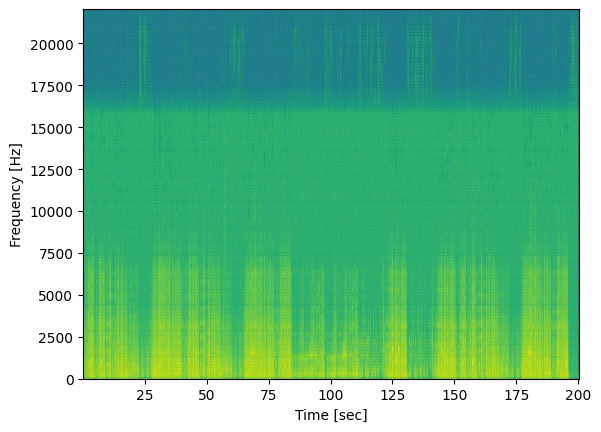

In [2]:
def describe_song(mp3):
    loaded_song = AudioSegment.from_mp3(mp3)
    raw_sample = loaded_song.get_array_of_samples()
    f, t, Sxx = signal.spectrogram(np.array(raw_sample), loaded_song.frame_rate)
    # To improve contrast, changing to a decibal scale
    plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
describe_song("./sample.mp3")

In [3]:
def extract_peaks(f, t, Sxx):
    """Finds peaks when looking at a single time slice."""
    peaks = [[], []]
    for i in range(Sxx.shape[1]):
        frequency_peaks = signal.find_peaks(Sxx[:,i], height=0.5, distance=100)
        for f_idx in frequency_peaks[0]:
            peaks[0].append(f_idx)
            peaks[1].append(i)
    return np.array([t[peaks[1]], f[peaks[0]]])

In [4]:
def extract_peaks_v2(f, t, Sxx):
    """Finds peaks when looking at both time and frequency dimensions."""
    frequency_bucket_size = 500
    frequency_buckets = np.int32(np.floor(f/frequency_bucket_size))
    time_bucket_size = 0.5
    time_buckets = np.int32(np.floor(t/time_bucket_size))
    peaks = [[], []]
    for t_itr in range(max(time_buckets)+1):
        for f_itr in range(max(frequency_buckets)+1):
            spectrogram_tile = Sxx[np.where(frequency_buckets == f_itr), :]
            spectrogram_tile = spectrogram_tile[:, :, np.where(time_buckets == t_itr)]
            tile_max = np.unravel_index(np.argmax(spectrogram_tile), spectrogram_tile.shape)
            peak = (np.where(frequency_buckets == f_itr)[0][tile_max[1]], 
                    np.where(time_buckets == t_itr)[0][tile_max[3]])
            # Removing uninteresting peaks
            if Sxx[peak[0], peak[1]] >= 1.0:
                peaks[0].append(peak[0])
                peaks[1].append(peak[1])
    return np.array([t[peaks[1]], f[peaks[0]]])

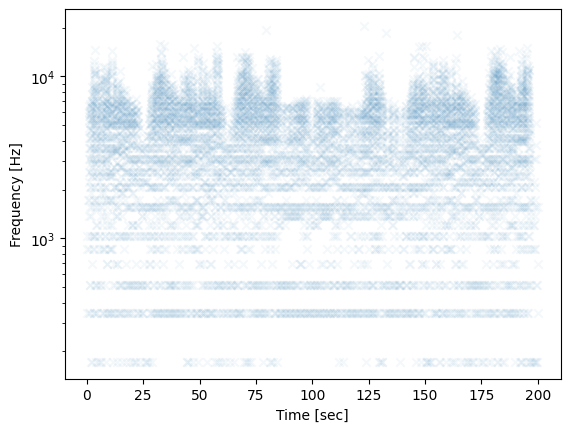

In [5]:
"""Peak locations, building the song constellation."""
def plot_peaks(mp3):
    loaded_song = AudioSegment.from_mp3(mp3)
    peak_points = extract_peaks_v2(*signal.spectrogram(np.array(loaded_song.get_array_of_samples()), 
                                                       loaded_song.frame_rate))
    plt.scatter(peak_points[0,:], peak_points[1,:], marker='x', alpha=0.05)
    plt.yscale('log')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
plot_peaks("./sample.mp3")

In [6]:
"""For each anchor point, compute hashes in a target zone."""
def extract_target_zone(anchor_point, peak_points):
    target_t_interval = (anchor_point[0]+0.1, anchor_point[0]+2)
    target_f_interval = (max(0,anchor_point[1]-500), anchor_point[1]+500)

    target_t_indices = np.logical_and(
        target_t_interval[0] <= peak_points[0,:], 
        peak_points[0,:] <= target_t_interval[1],
    )
    target_f_indices = np.logical_and(
        target_f_interval[0] <= peak_points[1,:],
        peak_points[1,:] <= target_f_interval[1]
    )
    target_indices = np.where(np.logical_and(target_t_indices, target_f_indices))[0]
    return peak_points[:, target_indices]

def compute_target_zone_fingerprints(anchor_point, target_zone_points):
    fingerprints = []
    if target_zone_points is None:
        return fingerprints
    for i in range(target_zone_points.shape[1]):
        fingerprints.append((
            # anchor point frequency
            anchor_point[1], 
            # target zone point frequency
            target_zone_points[1,i], 
            # time delta to anchor point
            target_zone_points[0,i]-anchor_point[0],
            # offset into the song
            anchor_point[0]
        ))
    return fingerprints

def compute_fingerprints(f, t, Sxx):
    peak_points = extract_peaks_v2(f, t, Sxx)
    fingerprints = []
    for i in range(peak_points.shape[1]):
        anchor_point = peak_points[:,i]
        fingerprints += compute_target_zone_fingerprints(anchor_point, 
                                                         extract_target_zone(anchor_point, peak_points))
    return fingerprints

def build_song_db(mp3s):    
    song_db = {}
    for mp3 in mp3s:
        print("adding song to database:", mp3)
        loaded_song = AudioSegment.from_mp3(mp3)
        for f in compute_fingerprints(*signal.spectrogram(np.array(loaded_song.get_array_of_samples()), 
                                       loaded_song.frame_rate)):
            db_key = (f[0], f[1], f[2])
            if db_key in song_db:
                if mp3 in song_db[db_key]:
                    song_db[db_key][mp3].append(f[3])
                else:
                    song_db[db_key][mp3] = [f[3]]
            else:
                song_db[db_key] = {mp3: [f[3]]}
    return song_db

song_db = build_song_db(["song-1.mp3"])

adding song to database: song-1.mp3


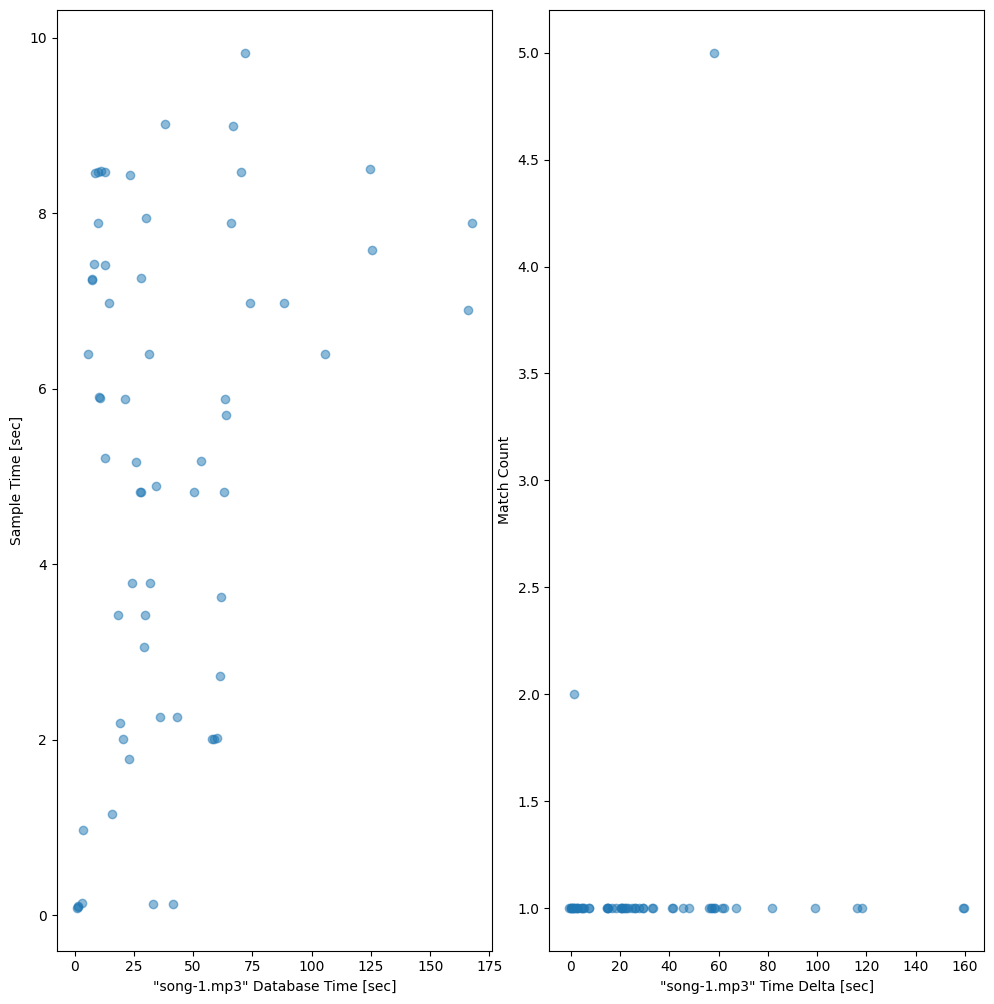

In [7]:
"""Testing against a subsample of the original song."""
def check_db_for_matches(song_db, raw_sample, raw_sample_frame_rate):
    sample_fingerprints = compute_fingerprints(*signal.spectrogram(np.array(raw_sample), 
                                                                   raw_sample_frame_rate))

    matches = {}
    for sample_fingerprint in sample_fingerprints:
        db_key = (sample_fingerprint[0], sample_fingerprint[1], sample_fingerprint[2])
        if db_key in song_db:
            for song in song_db[db_key]:
                for db_song_time_offset in song_db[db_key][song]:
                    if song in matches:
                        matches[song]['sample_offsets'].append(sample_fingerprint[3])
                        matches[song]['song_offsets'].append(db_song_time_offset)
                    else:
                        matches[song] = {
                            'sample_offsets': [sample_fingerprint[3]],
                            'song_offsets': [db_song_time_offset],
                        }
    return matches

def build_match_histogram(matches):
    matching_histogram = {}
    for song in matches:
        for t_tuple in zip(matches[song]['sample_offsets'], matches[song]['song_offsets']):
            offset = t_tuple[1] - t_tuple[0]
            if song in matching_histogram:
                if offset in matching_histogram[song]:
                    matching_histogram[song][offset] += 1
                else:
                    matching_histogram[song][offset] = 1
            else:
                matching_histogram[song] = {
                    offset: 1 
                }
    return matching_histogram

def plot_match_results(matches):
    matching_songs = sorted(list(matches.keys()))
    fig, ax = plt.subplots(len(matching_songs), 2, figsize=(10,10))
    ax = np.reshape(ax, (-1, 2))
    fig.tight_layout()
    for i in range(len(matching_songs)):
        target_song = matching_songs[i]
        ax[i, 0].scatter(matches[target_song]['song_offsets'], 
                matches[target_song]['sample_offsets'], 
                marker='o', alpha=0.5)
        ax[i, 0].set_ylabel('Sample Time [sec]')
        ax[i, 0].set_xlabel('"{}" Database Time [sec]'.format(target_song))

        matching_histogram = build_match_histogram(matches)
        offsets = []
        offset_hit_count = []
        for offset in sorted(matching_histogram[target_song].keys()):
            offsets.append(offset)
            offset_hit_count.append(matching_histogram[target_song][offset])
        ax[i, 1].scatter(offsets, offset_hit_count, marker='o', alpha=0.5)
        ax[i, 1].set_ylabel('Match Count')
        ax[i, 1].set_xlabel('"{}" Time Delta [sec]'.format(target_song))
    plt.show()
    
loaded_song = AudioSegment.from_mp3("song-1.mp3")
test_sample = loaded_song.get_array_of_samples()
matches = check_db_for_matches(song_db, test_sample[loaded_song.frame_rate*58:loaded_song.frame_rate*68],
                               loaded_song.frame_rate)
plot_match_results(matches)

In [8]:
# Let's now build a database with more songs
song_db = build_song_db([f for f in  os.popen("ls").read().split('\n') if f.startswith("song")])

adding song to database: song-1.mp3
adding song to database: song-2.mp3
adding song to database: song-3.mp3
adding song to database: song-4.mp3
adding song to database: song-5.mp3
adding song to database: song-6.mp3


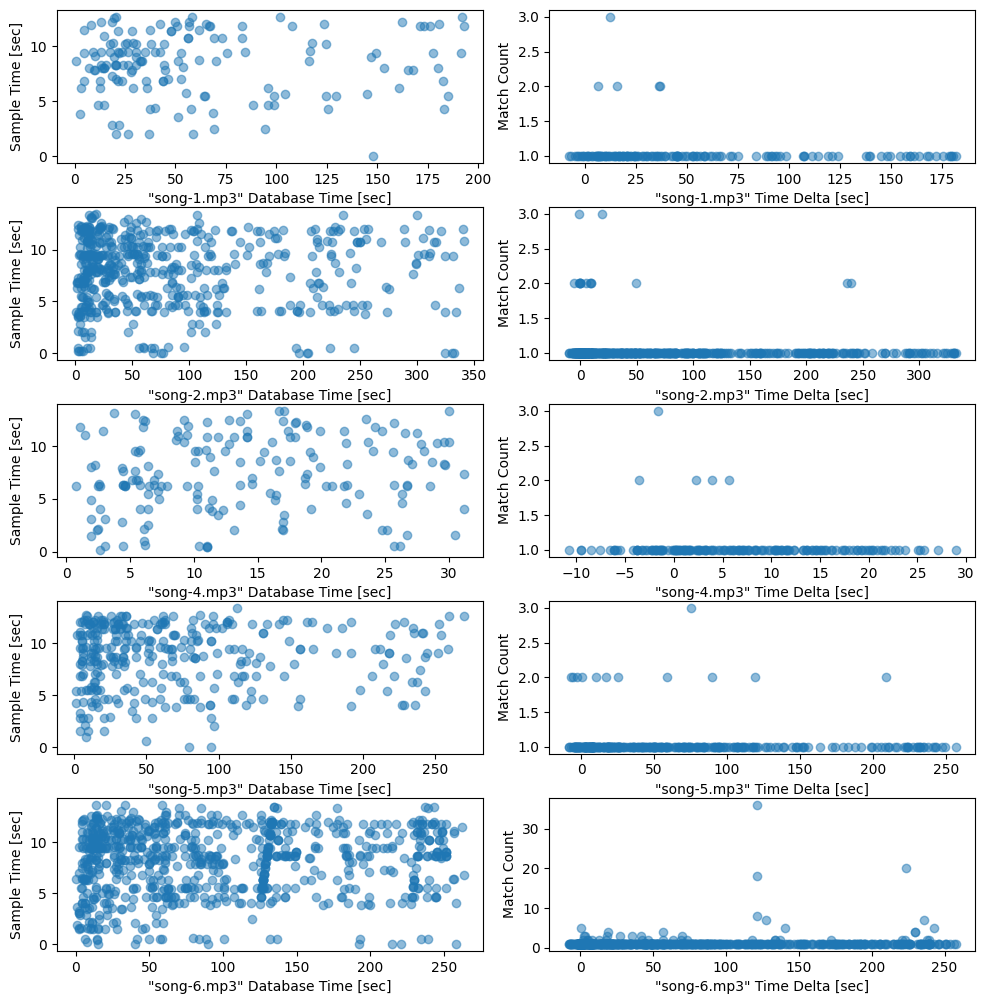

In [66]:
test_song = AudioSegment.from_mp3("song-6.mp3")
test_sample = test_song.get_array_of_samples()
matches = check_db_for_matches(song_db, test_sample[test_song.frame_rate*121:test_song.frame_rate*135],
                               test_song.frame_rate)
plot_match_results(matches)

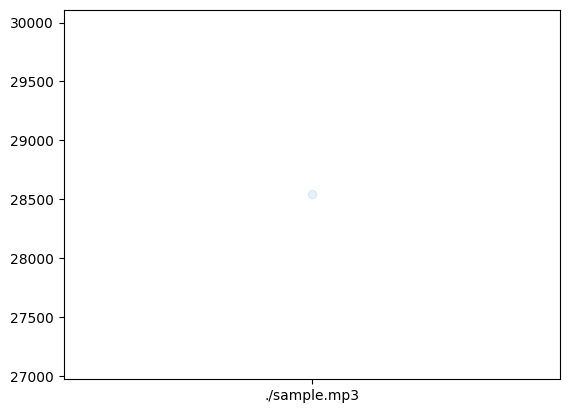

In [36]:
hist = {}
for offsets in song_db.values():
    for offset in offsets:
        if offset in hist:
            hist[offset] += 1
        else:
            hist[offset] = 1
x = []
y = []
for offset in sorted(hist.keys()):
    x.append(offset)
    y.append(hist[offset])
plt.scatter(x, y, marker='o', alpha=0.1)
plt.show()

In [41]:
print([f for f in  os.popen("ls").read().split('\n') if f.startswith("song")])

['song-1.mp3', 'song-2.mp3', 'song-3.mp3', 'song-4.mp3', 'song-5.mp3', 'song-6.mp3']


In [10]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

OSError: [Errno -9996] Invalid input device (no default output device)

In [15]:
pa = pyaudio.PyAudio()
pa.get_default_input_device_info()

OSError: No Default Input Device Available